# Finding the 15 best brazilian Real Estates

## Introduction

In this project,I performed a webscrapping over 322 brazilian Real States Tickers from 2 different websites, cleaned the data and executed a quantitative data manipulation based on the value investing strategy to decide the best 15 tickers. The motivation for this project was to help on my personal investments and develop my programming skills. 

## About the Strategy

The strategy to determine the best tickers named S-Rank Strategy was created by [Clube do valor](https://clubedovalor.com.br/blog/melhores-fiis-s-rank/) and their inspiration was the value investing principles. We can divide this strategy in two steps:

### 1. Filtering the data
####        a. Liquidity filter: 
Filtering the tickers where liquidity is higher than 200 thousands brazilian reais.
####        b. Type filter: 
Erasing Companies that focus on the development of new properties in our data. The reason for this is that  they are more risky, which could compromise the comparation with other types of REITs.
####        c. Estability filter: 
Eliminating companies where the difference between median and mean of the dividends paid are too high. 
####        d. Age filter: 
Filtering companies where the age is greater than 1 year.
### 2. Ranking the data
Finally, for this step, we rank the remaining Real Estates on 2 metrics: P/B (Price/Book) and Dividend Yield. Thus, each ticker is assigned a number (1, 2, 3...) based on how low its P/B is relative to others, and another (1, 2, 3...) based on how high the Dividend Yield is. The purpose is to select cheaper companies that are able to return more on our investments. After, the position of each Real Estate in these two rankings are added, and a new ranking formed, where the first 15 Tickers are the best based on this strategy.


# Table of contents

1. Webscraping and reading the data.
      1. Reading data from "fundamentus" website.    
      2. Applying the Liquidity filter.
      3. Performing a loop to webscrapp additional data.


2. Cleaning the data.
      1. Removing undesirable characters, and counting nan values
      2. Dropping rows with NaN values and assigning the correct dtype.  


3. Applying the S-Rank Strategy.
      1. Filtering the data.
      2. Sorting values to create the ranking.

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
from datetime import datetime
from datetime import date
import matplotlib as plt
import seaborn as sns

## 1. Webscraping and reading the data

### 1.A Reading data from "fundamentus" website

In [2]:
url='https://www.fundamentus.com.br/fii_resultado.php'

header = {
  "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36"  
 }
r = requests.get(url, headers=header)

realestate=pd.read_html(r.text, decimal=',',thousands='.')[0]

realestate=realestate[['Papel','Cotação','Dividend Yield','P/VP','Liquidez']]
realestate=realestate.rename(columns={'Papel':'Ticker','Cotação':'Price','P/VP':'P/B','Liquidez':'Liquidity'})
realestate=realestate.set_index('Ticker')

print(realestate)

          Price Dividend Yield   P/B  Liquidity
Ticker                                         
ABCP11    72.95          7,54%  0.79      79436
AEFI11   174.90          0,00%  1.24          0
AFCR11   103.15          6,95%  1.01          0
AFHI11    98.55         11,01%  1.02     859801
AFOF11    89.22         11,02%  0.88      75962
...         ...            ...   ...        ...
XPSF11     7.00         12,00%  0.08    1055370
XTED11     6.13          0,00%  0.44       7057
YCHY11  1000.00          0,00%  9.98          0
YUFI11   105.00          0,00%  1.00          8
ZIFI11  1189.89          0,40%  1.08      20897

[324 rows x 4 columns]


As it is possible to visualize in the dataframe above, the Dividend Yield column have some undesirable characters as "%", and "," instead of "." for decimal delimitator. However, we will not treat this column now, because we still have more data to add to the dataframe. In order to add the aditional data, we need to perform a loop over all of the Tickers, but since that we already have the liquidity column, it is convenient filter these dataframe first

### 1.B Applying the liquidity filter

In [3]:
realestate=realestate[realestate['Liquidity']>200000]
print(realestate.shape)

(137, 4)


Now that we have only 135 rows, instead of 323, we can execute a faster loop to find the aditional data needed for the analysis. 

### 1.C Perfoming a loop to webscrap additional data

In order to apply the remaining 3 filters, we need to webscrapp the mean and median of the dividends paid in the last 12 months, the goal of the company, and the date when the Ticker started to be traded on the Stock Market. For the dividends, we will use the pandas.read_html  to take the data from the [statusinvest](https://statusinvest.com.br/) website. However, for the remaining data this function is not effective, because this information is not displayed as table, so the BeautifulSoup library will be used to webscrapp it from the [fiis](https://fiis.com.br/) website.


In [4]:
realestate['Div_mean']=' ' # Mean of the dividends per share paid in the last 12 months.
realestate['Div_median']=' ' # Median of the dividends per share paid in the last 12 months.
realestate['Type']=' ' # Goal of the company.
realestate['Birthdate']=' ' # Date when the Ticker started to be traded on the Stock Market.
for i in (list(realestate.index)):
  url='https://statusinvest.com.br/fundos-imobiliarios/'+str.lower(i)
  r = requests.get(url, headers=header,verify=False)
  url2='https://fiis.com.br/'+str.lower(i)
  r2 =requests.get(url2,headers=header,verify=False)
  soup=BeautifulSoup(r2.content,'html.parser')
  spans=soup.find_all('span','value')

  try:
    spanlist=[]
    for span in spans:
      spanlist.append(span.text)
    realestate.loc[i,'Type']=spanlist[5]
    realestate.loc[i,'Birthdate']=spanlist[6]
    dividend=pd.read_html(r.text, decimal=',',thousands='.')[0]
    realestate.loc[i,'Div_mean']=dividend['Valor'].mean()
    realestate.loc[i,'Div_median']=dividend['Valor'].median()
  except:
    pass

realestate[['Birthdate','Type','Div_mean','Div_median']].head(40)

,Birthdate,Type,Div_mean,Div_median
Ticker,,,,
AFHI11,20/10/2020,Títulos e Valores Mobiliários Gestão Ativa,1.054167,1.125
AIEC11,24/08/2020,Renda Gestão Ativa,0.68,0.61
ALZR11,20/10/2017,Renda Gestão Ativa,0.690054,0.674241
ARCT11,31/07/2017,Híbrido Gestão Ativa,1.245146,1.280557
ARRI11,01/07/2019,Títulos e Valores Mobiliários Gestão Ativa,1.302953,1.305
BARI11,05/07/2018,Títulos e Valores Mobiliários Gestão Ativa,1.153333,1.125
BBFI11B,26/07/2004,Renda Gestão Passiva,26.808801,26.428727
BBPO11,30/09/2011,Renda Gestão Passiva,0.923916,0.89
BCFF11,27/08/2009,Títulos e Valores Mobiliários Gestão Ativa,0.510239,0.5


From the first 40 lines of columns webscrapped shown in the table above, it is possible to notice some undesirable characters as "--/--/--" and " ". This happened because not all of the data were available at the websites, so we need to clean all of this information before applying the strategy.

## 2. Cleaning the data

### 2.A Removing undesirable characters, and counting nan values

In [5]:
realestate['Birthdate']=realestate['Birthdate'].replace('--/--/--',np.nan,regex=False)
realestate['Birthdate']=realestate['Birthdate'].replace(' ',np.nan,regex=True)

realestate['Type']=realestate['Type'].replace('Não Informado',np.nan,regex=False)
realestate['Type']=realestate['Type'].replace(' ',np.nan,regex=False)

realestate['Div_mean']=realestate['Div_mean'].replace(' ',np.nan,regex=True)

realestate['Div_median']=realestate['Div_median'].replace(' ',np.nan,regex=True)

realestate['Dividend Yield']=realestate['Dividend Yield'].str.replace('.','',regex=True)
realestate['Dividend Yield']=realestate['Dividend Yield'].str.replace(',','.',regex=True)
realestate['Dividend Yield']=realestate['Dividend Yield'].str.rstrip('%')

realestate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, AFHI11 to XPSF11
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           137 non-null    float64
 1   Dividend Yield  137 non-null    object 
 2   P/B             137 non-null    float64
 3   Liquidity       137 non-null    int64  
 4   Div_mean        132 non-null    object 
 5   Div_median      132 non-null    object 
 6   Type            129 non-null    object 
 7   Birthdate       123 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 13.7+ KB


As printed above, the last 4 columns presents missing values, and some columns as "Dividend Yield", "Div_mean", "Div_median" and "Birthdate" were assigned with an incorrect Dtype. In order to apply the strategy, the rows with missing values will be dropped and the correct Dtype will be assigned. 

### 2.B Dropping rows with NaN values and assigning the correct dtype.

In [6]:
realestate.dropna(axis=0,how='any',inplace=True)

realestate['Dividend Yield']=realestate['Dividend Yield'].astype(float)/100

realestate[['Div_mean','Div_median']]=realestate[['Div_mean','Div_median']].astype(float)

realestate['Birthdate']=pd.to_datetime(realestate['Birthdate'],format='%d/%m/%Y',errors='coerce')

realestate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, AFHI11 to XPPR11
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Price           111 non-null    float64       
 1   Dividend Yield  111 non-null    float64       
 2   P/B             111 non-null    float64       
 3   Liquidity       111 non-null    int64         
 4   Div_mean        111 non-null    float64       
 5   Div_median      111 non-null    float64       
 6   Type            111 non-null    object        
 7   Birthdate       110 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 7.8+ KB


We can see that there is still a null value on the "Birthdate" column. 

In [7]:
realestate=realestate[realestate['Birthdate'].notnull()]
realestate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, AFHI11 to XPPR11
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Price           110 non-null    float64       
 1   Dividend Yield  110 non-null    float64       
 2   P/B             110 non-null    float64       
 3   Liquidity       110 non-null    int64         
 4   Div_mean        110 non-null    float64       
 5   Div_median      110 non-null    float64       
 6   Type            110 non-null    object        
 7   Birthdate       110 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 7.7+ KB


Finally, our dataframe is cleaned and ready to be filtered!

## 3. Applying the S-Rank Strategy

### 3.A Filtering the data.

In [8]:

#Filter 2: Type
realestate=realestate[realestate['Type']!='Desenvolvimento para Renda Gestão Ativa']

#Filter 3: |Mean-Median|
realestate['|Mean-Median|']=100*abs(realestate['Div_mean']-realestate['Div_median'])/realestate['Div_mean']
realestate=realestate[realestate['|Mean-Median|']<realestate['|Mean-Median|'].mean()]

#Filter 4: Age
realestate['today']=date.today() 
realestate['today']=pd.to_datetime(realestate['today'],format='%Y-%m-%d',errors='coerce')
realestate['Age']=(realestate['today']-realestate['Birthdate']).dt.days
realestate=realestate[realestate['Age']>365]

print(realestate.shape[0])

80


After applying the filters, it is possible to see that our resulting dataframe contains 77 rows, so let's finally obtain our ranking of the best 15 brazilian Real Estates.

### 3.B Sorting values and creating the ranking.

In [9]:
realestate=realestate.sort_values(by='Dividend Yield',ascending=False)
realestate['rank_div']=range(1,len(realestate)+1)
realestate=realestate.sort_values(by='P/B')
realestate['rank_P/B']=range(1,len(realestate)+1)

realestate['ranking']=realestate['rank_div']+realestate['rank_P/B']

ranking=realestate['ranking'].sort_values()

print('The best 15 tickers are: ')

print(ranking.iloc[0:15])

The best 15 tickers are: 
Ticker
BBFI11B    11
NSLU11     19
SEQR11     32
RELG11     34
HCTR11     39
BBPO11     41
BLMG11     42
XPPR11     45
GTWR11     45
RECT11     46
MORE11     47
RBFF11     50
MFII11     51
QAGR11     52
OUFF11     58
Name: ranking, dtype: int64


Finally, we got our ranking of the best 15 tickers based on the Rank-S strategy. However, it is important to emphasize that the result obtained in this work is not a purchase recommendation.

In [10]:
realestate=realestate.sort_values(by='ranking')
realestate['Classification']=' '
realestate.iloc[0:15,-1]='Top 15 Tickers'
realestate.iloc[15:,-1]='Others'


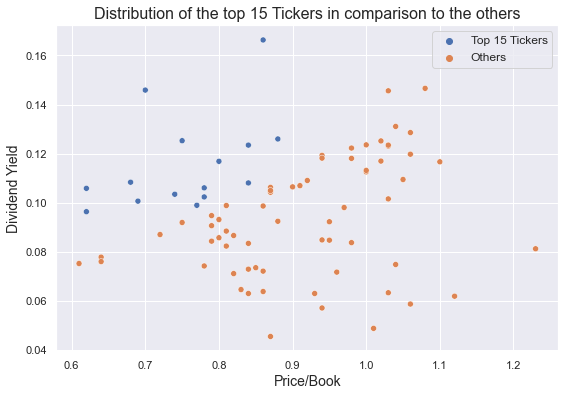

In [12]:
ax=sns.scatterplot(data=realestate, x='P/B', y='Dividend Yield',hue='Classification')
ax.set_xlabel('Price/Book',fontsize=14)
ax.set_ylabel('Dividend Yield',fontsize=14)
ax.set_title('Distribution of the top 15 Tickers in comparison to the others',fontsize=16)
ax.legend(loc='upper right',fontsize=12)
sns.set(rc={'figure.figsize':(9,6)});